In [1]:
#!pip install kaggle 
#!pip install missingno
#!pip install scikit-image
#!pip install rapidfuzz

In [2]:
import requests
import pandas as pd
import os

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import missingno as msno
from datetime import date

from skimage.feature import shape_index
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

import os
import unicodedata
import difflib

import shutil

from pathlib import Path

import re
from rapidfuzz import process, fuzz
from concurrent.futures import ThreadPoolExecutor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)


from kaggle.api.kaggle_api_extended import KaggleApi

In [3]:
#api = KaggleApi()
#api.authenticate()

#api.dataset_download_files('olistbr/brazilian-ecommerce', path='./dataset', unzip=True)

In [4]:
# Bu dosyanƒ±n (script) bulunduƒüu klas√∂r√º baz alƒ±yoruz
base_path = os.path.join(os.getcwd(), "dataset")

file_name_customers = "olist_customers_dataset.csv"
file_name_geolocation = "olist_geolocation_dataset.csv"
file_name_orderitems = "olist_order_items_dataset.csv"
file_name_orderpayments = "olist_order_payments_dataset.csv"
file_name_orderreviews = "olist_order_reviews_dataset.csv"
file_name_orders = "olist_orders_dataset.csv"
file_name_products = "olist_products_dataset.csv"
file_name_sellers = "olist_sellers_dataset.csv"
file_name_category_name_translation = "product_category_name_translation.csv"


# Tam yol
customers_path = os.path.join(base_path, file_name_customers)
geolocation_path = os.path.join(base_path, file_name_geolocation)
orderitems_path = os.path.join(base_path, file_name_orderitems)
orderpayments_path = os.path.join(base_path, file_name_orderpayments)
orderreviews_path = os.path.join(base_path, file_name_orderreviews)
orders_path = os.path.join(base_path, file_name_orders)
products_path = os.path.join(base_path, file_name_products)
sellers_path = os.path.join(base_path, file_name_sellers)
product_category_name_translation_path = os.path.join(base_path, file_name_category_name_translation)

def load(dataset):
    try:
        data = pd.read_csv(dataset)
        return data
    except FileNotFoundError:
        print(f"Dosya bulunamadƒ±: {dataset}")
        return None

In [5]:
df_customers = load(customers_path)
df_customers.head()

customer_id                customer_unique_id  customer_zip_code_prefix          customer_city customer_state
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0                     14409                 franca             SP
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3                      9790  sao bernardo do campo             SP
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e                      1151              sao paulo             SP
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c                      8775        mogi das cruzes             SP
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066                     13056               campinas             SP

In [6]:
df_geo_avg = load(geolocation_path)
df_geo_avg.head()

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng geolocation_city geolocation_state
0                         1037          -23.546          -46.639        sao paulo                SP
1                         1046          -23.546          -46.645        sao paulo                SP
2                         1046          -23.546          -46.643        sao paulo                SP
3                         1041          -23.544          -46.639        sao paulo                SP
4                         1035          -23.542          -46.642        sao paulo                SP

In [7]:
# zip prefix bazƒ±nda √∂zet tablo
summary = (
    df_geo_avg.groupby("geolocation_zip_code_prefix")
    .agg(
        city_count=("geolocation_city", "nunique"),     # ka√ß farklƒ± ≈üehir var
        state_count=("geolocation_state", "nunique"),   # ka√ß farklƒ± eyalet var
        coord_count=("geolocation_lat", "count"),       # toplam satƒ±r sayƒ±sƒ± (koordinat sayƒ±sƒ±)
        lat_std=("geolocation_lat", "std"),             # enlem sapmasƒ±
        lng_std=("geolocation_lng", "std")              # boylam sapmasƒ±
    )
    .reset_index()
)

summary.head()


geolocation_zip_code_prefix  city_count  state_count  coord_count  lat_std  lng_std
0                         1001           2            1           26    0.001    0.000
1                         1002           2            1           13    0.001    0.001
2                         1003           2            1           17    0.000    0.001
3                         1004           2            1           22    0.001    0.000
4                         1005           2            1           25    0.000    0.001

In [8]:
# %95 e≈üiklerini hesapla
lat_thresh = summary['lat_std'].quantile(0.95)
lng_thresh = summary['lng_std'].quantile(0.95)

# geni≈ü alan zip‚Äôleri se√ß
wide_zips = summary[
    (summary['lat_std'] > lat_thresh) |
    (summary['lng_std'] > lng_thresh)
]

print("Lat std i√ßin %95 e≈üik:", lat_thresh)
print("Lng std i√ßin %95 e≈üik:", lng_thresh)
print("E≈üik √ºzerinde ka√ß kayƒ±t var:", len(wide_zips))
wide_zips.head(10)



Lat std i√ßin %95 e≈üik: 0.04056525284991052
Lng std i√ßin %95 e≈üik: 0.045473794164270054
E≈üik √ºzerinde ka√ß kayƒ±t var: 1272


geolocation_zip_code_prefix  city_count  state_count  coord_count  lat_std  lng_std
130                         1239           2            1          152    0.012    0.066
202                         1417           2            1           86    0.026    0.079
215                         1430           2            1           11    0.145    0.013
216                         1431           2            1           13    0.117    0.011
257                         1513           1            1           24    0.023    0.072
406                         2169           2            1           45    0.106    0.071
458                         2237           1            1            8    0.136    0.045
508                         2290           2            1            3    0.109    0.047
531                         2323           2            1           56    0.044    0.053
532                         2324           2            1           48    0.087    0.033

In [9]:
# summary tablosundan gerekli s√ºtunlarƒ± alƒ±yoruz
zip_summary = summary[['geolocation_zip_code_prefix', 'city_count', 'state_count']].copy()

# Durum s√ºtunu ekleyelim
def zip_type(row):
    if row['state_count'] > 1:
        return 'Farklƒ± eyaletlerde'
    elif row['state_count'] == 1 and row['city_count'] > 1:
        return 'Aynƒ± eyalette farklƒ± ≈üehirler'
    else:
        return 'Tek ≈üehir, tek eyalet'

zip_summary['type'] = zip_summary.apply(zip_type, axis=1)

# Sƒ±ralama: √∂nce eyalet sayƒ±sƒ±na g√∂re, sonra ≈üehir sayƒ±sƒ±na g√∂re
zip_summary_sorted = zip_summary.sort_values(
    by=['state_count', 'city_count'], 
    ascending=[False, False]
).reset_index(drop=True)

# √ñrnek olarak ilk 20 satƒ±rƒ± g√∂ster
zip_summary_sorted.head(20)

geolocation_zip_code_prefix  city_count  state_count                           type
0                         72915           3            2             Farklƒ± eyaletlerde
1                          2116           2            2             Farklƒ± eyaletlerde
2                          4011           2            2             Farklƒ± eyaletlerde
3                         78557           2            2             Farklƒ± eyaletlerde
4                         80630           2            2             Farklƒ± eyaletlerde
5                         21550           1            2             Farklƒ± eyaletlerde
6                         23056           1            2             Farklƒ± eyaletlerde
7                         79750           1            2             Farklƒ± eyaletlerde
8                          6900           5            1  Aynƒ± eyalette farklƒ± ≈üehirler
9                         13318           5            1  Aynƒ± eyalette farklƒ± ≈üehirler
10                        13454           5            1  Aynƒ± eyalette farklƒ± ≈üehirler
11                        13455           5            1  Aynƒ± eyalette farklƒ± ≈üehirler
12                        13457           5            1  Aynƒ± eyalette farklƒ± ≈üehirler
13                        17970           5            1  Aynƒ± eyalette farklƒ± ≈üehirler
14                        28950           5            1  Aynƒ± eyalette farklƒ± ≈üehirler
15                        42850           5            1  Aynƒ± eyalette farklƒ± ≈üehirler
16                        78290           5            1  Aynƒ± eyalette farklƒ± ≈üehirler
17                         9780           4            1  Aynƒ± eyalette farklƒ± ≈üehirler
18                        13450           4            1  Aynƒ± eyalette farklƒ± ≈üehirler
19                        13453           4            1  Aynƒ± eyalette farklƒ± ≈üehirler

In [10]:
# Aynƒ± eyalette birden fazla ≈üehir
same_state_multi_city = zip_summary_sorted[(zip_summary_sorted['state_count'] == 1) & (zip_summary_sorted['city_count'] > 1)]
same_state_multi_city_count = same_state_multi_city.shape[0]

# Farklƒ± eyaletlerde olan zip kodlarƒ±
multi_state = zip_summary_sorted[zip_summary_sorted['state_count'] > 1]
multi_state_count = multi_state.shape[0]

same_state_multi_city_count, multi_state_count


(8551, 8)

In [11]:
# Farklƒ± eyaletleri kapsayan zip kodlarƒ±
multi_state_zips = zip_summary_sorted[zip_summary_sorted['state_count'] > 1]

# ƒ∞lk 10 satƒ±rƒ± g√∂ster
multi_state_zips.head(10)

# ƒ∞stersen t√ºm listeyi g√∂rmek i√ßin:
multi_state_zips


geolocation_zip_code_prefix  city_count  state_count                type
0                        72915           3            2  Farklƒ± eyaletlerde
1                         2116           2            2  Farklƒ± eyaletlerde
2                         4011           2            2  Farklƒ± eyaletlerde
3                        78557           2            2  Farklƒ± eyaletlerde
4                        80630           2            2  Farklƒ± eyaletlerde
5                        21550           1            2  Farklƒ± eyaletlerde
6                        23056           1            2  Farklƒ± eyaletlerde
7                        79750           1            2  Farklƒ± eyaletlerde

In [12]:
# Farklƒ± eyaletleri kapsayan zip kodlarƒ± ve eyalet isimleri
state_counts = df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_state'].nunique()
zip_diff_states = state_counts[state_counts > 1].reset_index()
zip_diff_states = zip_diff_states.merge(
    df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_state'].unique().reset_index(),
    on='geolocation_zip_code_prefix'
)
zip_diff_states = zip_diff_states.rename(columns={'geolocation_state': 'states'})
zip_diff_states


geolocation_zip_code_prefix  geolocation_state_x geolocation_state_y
0                         2116                    2            [SP, RN]
1                         4011                    2            [SP, AC]
2                        21550                    2            [RJ, AC]
3                        23056                    2            [RJ, AC]
4                        72915                    2            [GO, DF]
5                        78557                    2            [MT, RO]
6                        79750                    2            [MS, RS]
7                        80630                    2            [PR, SC]

In [13]:
city_counts = df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_city'].nunique()
zip_same_state_diff_city = city_counts[(city_counts > 1) & (df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_state'].nunique() == 1)]
zip_same_state_diff_city = zip_same_state_diff_city.reset_index()
zip_same_state_diff_city = zip_same_state_diff_city.merge(
    df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_city'].unique().reset_index(),
    on='geolocation_zip_code_prefix'
)
zip_same_state_diff_city = zip_same_state_diff_city.rename(columns={'geolocation_city': 'cities'})
zip_same_state_diff_city.head()

geolocation_zip_code_prefix  geolocation_city_x      geolocation_city_y
0                         1001                   2  [sao paulo, s√£o paulo]
1                         1002                   2  [sao paulo, s√£o paulo]
2                         1003                   2  [sao paulo, s√£o paulo]
3                         1004                   2  [sao paulo, s√£o paulo]
4                         1005                   2  [sao paulo, s√£o paulo]

In [14]:
# Her zip i√ßin state ve city bilgisi
zip_info = (
    df_geo_avg
    .groupby('geolocation_zip_code_prefix')
    .agg(
        state_count=('geolocation_state', 'nunique'),
        states=('geolocation_state', lambda x: list(x.unique())),
        max_city_count=('geolocation_city', lambda x: x.nunique())  # her zip i√ßindeki toplam farklƒ± ≈üehir sayƒ±sƒ±
    )
    .reset_index()
)

# Sƒ±ralama: √∂nce state_count, sonra max_city_count
zip_info_sorted = zip_info.sort_values(
    by=['state_count', 'max_city_count'], 
    ascending=[False, False]
).reset_index(drop=True)

zip_info_sorted.head(20)



geolocation_zip_code_prefix  state_count    states  max_city_count
0                         72915            2  [GO, DF]               3
1                          2116            2  [SP, RN]               2
2                          4011            2  [SP, AC]               2
3                         78557            2  [MT, RO]               2
4                         80630            2  [PR, SC]               2
5                         21550            2  [RJ, AC]               1
6                         23056            2  [RJ, AC]               1
7                         79750            2  [MS, RS]               1
8                          6900            1      [SP]               5
9                         13318            1      [SP]               5
10                        13454            1      [SP]               5
11                        13455            1      [SP]               5
12                        13457            1      [SP]               5
13                        17970            1      [SP]               5
14                        28950            1      [RJ]               5
15                        42850            1      [BA]               5
16                        78290            1      [MT]               5
17                         9780            1      [SP]               4
18                        13450            1      [SP]               4
19                        13453            1      [SP]               4

In [15]:
df_orderitems = load(orderitems_path)
df_orderitems.head()

order_id  order_item_id                        product_id                         seller_id  shipping_limit_date   price  freight_value
0  00010242fe8c5a6d1ba2dd792cb16214              1  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202  2017-09-19 09:45:35  58.900         13.290
1  00018f77f2f0320c557190d7a144bdd3              1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36  2017-05-03 11:05:13 239.900         19.930
2  000229ec398224ef6ca0657da4fc703e              1  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d  2018-01-18 14:48:30 199.000         17.870
3  00024acbcdf0a6daa1e931b038114c75              1  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4  2018-08-15 10:10:18  12.990         12.790
4  00042b26cf59d7ce69dfabb4e55b4fd9              1  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87  2017-02-13 13:57:51 199.900         18.140

In [16]:
df_orderpayments = load(orderpayments_path)
df_orderpayments.head()

order_id  payment_sequential payment_type  payment_installments  payment_value
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card                     8         99.330
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card                     1         24.390
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card                     1         65.710
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card                     8        107.780
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card                     2        128.450

In [17]:
df_orderreviews = load(orderreviews_path)
df_orderreviews.head()

review_id                          order_id  review_score review_comment_title                             review_comment_message review_creation_date review_answer_timestamp
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb             4                  NaN                                                NaN  2018-01-18 00:00:00     2018-01-18 21:46:59
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33             5                  NaN                                                NaN  2018-03-10 00:00:00     2018-03-11 03:05:13
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b             5                  NaN                                                NaN  2018-02-17 00:00:00     2018-02-18 14:36:24
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b             5                  NaN              Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00     2017-04-21 22:02:06
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1             5                  NaN  Parab√©ns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00     2018-03-02 10:26:53

In [18]:
df_orders = load(orders_path)
df_orders.head()

order_id                       customer_id order_status order_purchase_timestamp    order_approved_at order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15          2017-10-04 19:55:00           2017-10-10 21:25:13           2017-10-18 00:00:00
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27          2018-07-26 14:31:00           2018-08-07 15:27:45           2018-08-13 00:00:00
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23          2018-08-08 13:50:00           2018-08-17 18:06:29           2018-09-04 00:00:00
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59          2017-11-22 13:39:59           2017-12-02 00:28:42           2017-12-15 00:00:00
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29          2018-02-14 19:46:34           2018-02-16 18:17:02           2018-02-26 00:00:00

In [19]:
df_products = load(products_path)
df_products.head()

product_id  product_category_name  product_name_lenght  product_description_lenght  product_photos_qty  product_weight_g  product_length_cm  product_height_cm  product_width_cm
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria               40.000                     287.000               1.000           225.000             16.000             10.000            14.000
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes               44.000                     276.000               1.000          1000.000             30.000             18.000            20.000
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer               46.000                     250.000               1.000           154.000             18.000              9.000            15.000
3  cef67bcfe19066a932b7673e239eb23d                  bebes               27.000                     261.000               1.000           371.000             26.000              4.000            26.000
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas               37.000                     402.000               4.000           625.000             20.000             17.000            13.000

In [20]:
df_sellers = load(sellers_path)
df_sellers.head()

seller_id  seller_zip_code_prefix        seller_city seller_state
0  3442f8959a84dea7ee197c632cb2df15                   13023           campinas           SP
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844         mogi guacu           SP
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031     rio de janeiro           RJ
3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195          sao paulo           SP
4  51a04a8a6bdcb23deccc82b0b80742cf                   12914  braganca paulista           SP

### Farkli yazim sekilleri nedeniyle tekrar eden ayni sehir ve eyaletlerin tespiti

In [21]:
# 1Ô∏è‚É£ Geli≈ümi≈ü ≈üehir normalizasyonu
def normalize_city_advanced(name: str) -> str:
    if pd.isna(name):
        return ""
    name = name.strip().lower()
    # Aksanlarƒ± kaldƒ±r
    name = ''.join(c for c in unicodedata.normalize('NFD', name) if unicodedata.category(c) != 'Mn')
    # Nokta, tire, apostrof, bo≈üluk gibi karakterleri kaldƒ±r
    name = re.sub(r'[\s\.\-\'"]', '', name)
    return name

In [22]:
# 2Ô∏è‚É£ Benzer ≈üehirleri gruplayƒ±p tekille≈ütirme
def deduplicate_cities(city_list, threshold: float = 0.9) -> dict:
    mapping = {}
    for i, city in enumerate(city_list):
        if city not in mapping:
            mapping[city] = city  # ilk g√∂rd√ºƒü√ºn√º referans al
        for other in city_list[i+1:]:
            similarity = difflib.SequenceMatcher(None, city, other).ratio()
            if similarity >= threshold:
                mapping[other] = mapping[city]
    return mapping

In [23]:
# 3. Eyalet bazƒ±nda ≈üehir e≈üle≈ütirme (multithreading)
def deduplicate_state(row, state_col, threshold):
    state = row[state_col]
    city_list = list(row['cities'])
    mapping = deduplicate_names_rf(city_list, threshold)
    return {(state, k): v for k, v in mapping.items()}

In [24]:
# 4. Ana fonksiyon (≈üehir + eyalet)

def clean_city_names(df, city_col, state_col, similarity_threshold=0.9):
    """
    T√ºm ≈üehir isimlerini normalize eder ve benzer ≈üehirleri tekille≈ütirir.
    """
    # Normalize edilmi≈ü ≈üehir s√ºtunu
    df['city_norm'] = df[city_col].apply(normalize_city_advanced)

    # Eyalet bazƒ±nda ≈üehir listesi
    state_cities = (
        df.groupby(state_col)['city_norm']
        .unique()
        .reset_index()
        .rename(columns={'city_norm': 'cities'})
    )

    # Eyalet bazlƒ± e≈üle≈ümeler
    all_mappings = {}
    for idx, row in state_cities.iterrows():
        state = row[state_col]
        city_list = list(row['cities'])
        mapping = deduplicate_cities(city_list, threshold=similarity_threshold)
        for raw_city, clean_city in mapping.items():
            all_mappings[(state, raw_city)] = clean_city

    # Orijinal tabloyu g√ºncelle
    df[city_col] = df.apply(
        lambda row: all_mappings.get((row[state_col], row['city_norm']), row['city_norm']),
        axis=1
    )

    # Ge√ßici s√ºtunu kaldƒ±r
    df = df.drop(columns=['city_norm'])
    
    return df

In [25]:
# geolocation tablosu i√ßin
df_geo_avg = clean_city_names(df_geo_avg, city_col='geolocation_city', state_col='geolocation_state')

In [26]:
# Customers tablosu i√ßin
df_customers = clean_city_names(df_customers, city_col='customer_city', state_col='customer_state')


In [27]:
# Sellers tablosu i√ßin
df_sellers = clean_city_names(df_sellers, city_col='seller_city', state_col='seller_state')

## Temizleme i≈üleminden sonra hala tekrar eden ≈üehir isimleri kaldƒ± mƒ± kontrol

In [28]:
def check_remaining_similar_cities(df, city_col, state_col, threshold=0.9):
    """
    Temizlenmi≈ü tabloda hala birbirine benzer ≈üehir var mƒ± diye kontrol eder.
    """
    state_cities = (
        df.groupby(state_col)[city_col]
        .unique()
        .reset_index()
        .rename(columns={city_col: 'cities'})
    )

    all_duplicates = {}
    for _, row in state_cities.iterrows():
        state = row[state_col]
        cities = row['cities']
        duplicates = []
        for i, city in enumerate(cities):
            for other in cities[i+1:]:
                similarity = difflib.SequenceMatcher(None, city, other).ratio()
                if similarity >= threshold:
                    duplicates.append((city, other, similarity))
        if duplicates:
            all_duplicates[state] = duplicates

    if not all_duplicates:
        print("‚úÖ Hi√ß tekrar eden veya benzer ≈üehir kalmadƒ±.")
    else:
        for state, duplicates in all_duplicates.items():
            print(f"\nEyalet: {state}")
            for dup in duplicates:
                print(f" - {dup[0]} ~ {dup[1]} (benzerlik: {dup[2]:.2f})")



In [29]:
check_remaining_similar_cities(df_geo_avg, city_col='geolocation_city', state_col='geolocation_state' )

‚úÖ Hi√ß tekrar eden veya benzer ≈üehir kalmadƒ±.


In [30]:
check_remaining_similar_cities(df_sellers, city_col='seller_city', state_col='seller_state' )

‚úÖ Hi√ß tekrar eden veya benzer ≈üehir kalmadƒ±.


In [31]:
check_remaining_similar_cities(df_customers, city_col='customer_city', state_col='customer_state' )

‚úÖ Hi√ß tekrar eden veya benzer ≈üehir kalmadƒ±.


# DATA MODELING

-----------------------------
Ô∏è1-  Basit sayƒ±sal ID olu≈üturma fonksiyonu
-----------------------------

In [32]:
# Prefiksli ID olu≈üturma (ID olan tablolar)
def create_prefixed_id(df, original_id_col, new_id_col, prefix):
    df = df.copy()
    id_map = {old_id: f"{prefix}{str(i+1).zfill(3)}" for i, old_id in enumerate(df[original_id_col])}
    df[new_id_col] = df[original_id_col].map(id_map)
    return df, id_map

# Prefiksli ID olu≈üturma (ID olmayan tablolar)
def create_prefixed_id_no_col(df, new_id_col, prefix):
    df = df.copy()
    df[new_id_col] = [f"{prefix}{str(i+1).zfill(3)}" for i in range(len(df))]
    return df


Ô∏è2- PK‚Äôlarƒ± Prefiksli ID‚Äôye √áevirme ve Mapping Saklama
-----------------------------


In [33]:

# Sellers
df_sellers, seller_id_map = create_prefixed_id(df_sellers, "seller_id", "seller_id_pref", "SEL")

# Orders
df_orders, order_id_map = create_prefixed_id(df_orders, "order_id", "order_id_pref", "ORD")

# Products
df_products, product_id_map = create_prefixed_id(df_products, "product_id", "product_id_pref", "PRO")

# Customers
df_customers, customers_id_map = create_prefixed_id(df_customers, "customer_id", "customer_id_pref", "CUS")


# Order Items (ID olmayan ama √ºr√ºn sayƒ±sƒ± kolonu korunacak)
df_orderitems = df_orderitems.rename(columns={"order_item_id": "order_item_number"})  # PK deƒüil
df_orderitems = create_prefixed_id_no_col(df_orderitems, "order_item_pref", "OIT")
# Order Payments
df_orderpayments= create_prefixed_id_no_col(df_orderpayments, "orderpayment_id_pref", "PAY")
# Geolocation (ID yok)
df_geo_avg = create_prefixed_id_no_col(df_geo_avg, "geolocation_id_pref", "GEO")


In [34]:
# Orders ‚Üí customer_id_pref ekle
df_orders["customer_id_pref"] = df_orders["customer_id"].map(customers_id_map)

# Order Items ‚Üí order_id_pref, product_id_pref, seller_id_pref ekle
df_orderitems["order_id_pref"] = df_orderitems["order_id"].map(order_id_map)
df_orderitems["product_id_pref"] = df_orderitems["product_id"].map(product_id_map)
df_orderitems["seller_id_pref"] = df_orderitems["seller_id"].map(seller_id_map)

# Order Payments ‚Üí order_id_pref ekle
df_orderpayments["order_id_pref"] = df_orderpayments["order_id"].map(order_id_map)


In [35]:
# 1. E≈üsiz customer_unique_id listesi
unique_customers = df_customers[['customer_unique_id']].drop_duplicates().reset_index(drop=True)

# 2. Yeni ID olu≈ütur
unique_customers['cusUni'] = [f"CUSUNI{str(i+1).zfill(4)}" for i in range(len(unique_customers))]

# 3. Orijinal tabloya merge ile ekle
df_customers = df_customers.merge(unique_customers, on='customer_unique_id', how='left')


In [36]:
df_customers.head()

customer_id                customer_unique_id  customer_zip_code_prefix       customer_city customer_state customer_id_pref      cusUni
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0                     14409              franca             SP           CUS001  CUSUNI0001
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3                      9790  saobernardodocampo             SP           CUS002  CUSUNI0002
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e                      1151            saopaulo             SP           CUS003  CUSUNI0003
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c                      8775       mogidascruzes             SP           CUS004  CUSUNI0004
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066                     13056            campinas             SP           CUS005  CUSUNI0005

In [37]:
# 1. Her customer_unique_id ka√ß farklƒ± cusUni ile e≈üle≈ümi≈ü 
check_unique = df_customers.groupby('customer_unique_id')['cusUni'].nunique().reset_index()
check_unique.rename(columns={'cusUni': 'num_unique_ids'}, inplace=True)

# 2. Eƒüer her customer_unique_id yalnƒ±zca bir cusUni ile e≈üle≈ümi≈üse tamamdƒ±r
problem_customers = check_unique[check_unique['num_unique_ids'] != 1]

if problem_customers.empty:
    print("T√ºm m√º≈üteri unique ID‚Äôleri d√ºzg√ºn ≈üekilde tek bir yeni ID ile e≈üle≈ümi≈ü.")
else:
    print("Dikkat! Bazƒ± m√º≈üteri unique ID‚Äôleri birden fazla yeni ID ile e≈üle≈ümi≈ü:")
    print(problem_customers)



T√ºm m√º≈üteri unique ID‚Äôleri d√ºzg√ºn ≈üekilde tek bir yeni ID ile e≈üle≈ümi≈ü.


In [38]:
customer_id = "1b6c7548a2a1f9037c1fd3ddfed95f33"

customer_info = df_customers[df_customers['customer_unique_id'] == customer_id]

customer_info


customer_id                customer_unique_id  customer_zip_code_prefix customer_city customer_state customer_id_pref      cusUni
7012   53e16f83735cfe02bf83ef6481ca241e  1b6c7548a2a1f9037c1fd3ddfed95f33                     38301     ituiutaba             MG          CUS7013  CUSUNI6996
12164  95b9cacc4bc81c3a0a33967bcde6fcd8  1b6c7548a2a1f9037c1fd3ddfed95f33                     38301     ituiutaba             MG         CUS12165  CUSUNI6996
16824  41a16488effb86580d7a89f8aa19a03b  1b6c7548a2a1f9037c1fd3ddfed95f33                     38301     ituiutaba             MG         CUS16825  CUSUNI6996
24987  fff7466a253c0e59499ea943462c10f9  1b6c7548a2a1f9037c1fd3ddfed95f33                     38301     ituiutaba             MG         CUS24988  CUSUNI6996
50663  c2ff01bd4fa72f9487ee397f6c5989d2  1b6c7548a2a1f9037c1fd3ddfed95f33                     38301     ituiutaba             MG         CUS50664  CUSUNI6996
65287  9a4578c9dd9dce6517d583cb5eca0276  1b6c7548a2a1f9037c1fd3ddfed95f33                     38301     ituiutaba             MG         CUS65288  CUSUNI6996
66714  ee5c2e36a79081c2440e61990ec2f3af  1b6c7548a2a1f9037c1fd3ddfed95f33                     38301     ituiutaba             MG         CUS66715  CUSUNI6996

Customers ve Sellers  tablosuna geolocation_id_pref ekle

Artƒ±k zip code ve city/state kolonlarƒ±nƒ± customers & sellers'tan silebiliriz

Orijinal ID‚Äôleri sil

In [39]:
# Orijinal ID kolonlarƒ±
drop_cols = {
    "customers": ["customer_id", "customer_unique_id"],
    "sellers": ["seller_id", "unique_id"],
    "orders": ["order_id", "customer_id", "unique_id"],
    "order_items": ["order_id", "product_id", "seller_id", "unique_id"],
    "products": ["product_id", "unique_id"],
    "order_payments": ["orderpayment_id", "order_id", "unique_id"],
    "df_geo_avg": ["unique_id"]
}

dfs = {
    "customers": df_customers,
    "sellers": df_sellers,
    "orders": df_orders,
    "order_items": df_orderitems,
    "products": df_products,
    "order_payments": df_orderpayments,
    "df_geo_avg": df_geo_avg
}

for name, df in dfs.items():
    cols_to_drop = [c for c in drop_cols[name] if c in df.columns]
    dfs[name] = df.drop(columns=cols_to_drop)

(df_customers, df_sellers, df_orders, df_orderitems,
 df_products, df_orderpayments, df_geo_avg) = [dfs[k] for k in dfs]
  

Prefiksli ID‚Äôleri ba≈üa ta≈üƒ±

In [40]:
def move_prefixed_id_first(df, prefixed_id_col, fk_cols=[]):
    df = df.copy()
    cols = [prefixed_id_col] + fk_cols + [c for c in df.columns if c not in ([prefixed_id_col] + fk_cols)]
    return df[cols]

# Ba≈üta prefiksli ID, FK‚Äôlar da ba≈üa
df_customers = move_prefixed_id_first(df_customers, "customer_id_pref")
df_sellers = move_prefixed_id_first(df_sellers, "seller_id_pref")
df_orders = move_prefixed_id_first(df_orders, "order_id_pref", fk_cols=["customer_id_pref"])
df_orderitems = move_prefixed_id_first(df_orderitems, "order_item_pref", fk_cols=["order_id_pref", "product_id_pref", "seller_id_pref"])
df_products = move_prefixed_id_first(df_products, "product_id_pref")
df_orderpayments = move_prefixed_id_first(df_orderpayments, "orderpayment_id_pref", fk_cols=["order_id_pref"])
df_geo_avg = move_prefixed_id_first(df_geo_avg, "geolocation_id_pref")


In [41]:
df_geo_avg.head()

geolocation_id_pref  geolocation_zip_code_prefix  geolocation_lat  geolocation_lng geolocation_city geolocation_state
0              GEO001                         1037          -23.546          -46.639         saopaulo                SP
1              GEO002                         1046          -23.546          -46.645         saopaulo                SP
2              GEO003                         1046          -23.546          -46.643         saopaulo                SP
3              GEO004                         1041          -23.544          -46.639         saopaulo                SP
4              GEO005                         1035          -23.542          -46.642         saopaulo                SP

In [42]:
df_geolocation = df_geo_avg

In [43]:

# 1. GEO tablosundan ortalama koordinat √ßƒ±kar (geo_avg)
df_geo_avg = (
    df_geolocation
    .groupby("geolocation_zip_code_prefix")[["geolocation_lat", "geolocation_lng"]]
    .mean()
    .reset_index()
    .rename(columns={
        "geolocation_zip_code_prefix": "zip_prefix",
        "geolocation_lat": "lat_avg",
        "geolocation_lng": "lng_avg"
    })
)

# 2. CUSTOMERS tablosuna ortalama koordinat ekle
df_customers = df_customers.merge(
    df_geo_avg,
    left_on="customer_zip_code_prefix",
    right_on="zip_prefix",
    how="left"
).drop(columns=["zip_prefix"])  # temp kolon gerekmez

# 3. SELLERS tablosuna ortalama koordinat ekle
df_sellers = df_sellers.merge(
    df_geo_avg,
    left_on="seller_zip_code_prefix",
    right_on="zip_prefix",
    how="left"
).drop(columns=["zip_prefix"])

# Artƒ±k:
# df_geo_full  -> ham geo data (zip + lat + lng + pk)
# geo_avg      -> zip bazlƒ± ortalama koordinatlar
# df_customers -> m√º≈üteri tablosu + ortalama koordinatlar
# df_sellers   -> satƒ±cƒ± tablosu + ortalama koordinatlar


In [44]:
df_geo_avg.head()

zip_prefix  lat_avg  lng_avg
0        1001  -23.550  -46.634
1        1002  -23.548  -46.635
2        1003  -23.549  -46.636
3        1004  -23.550  -46.635
4        1005  -23.549  -46.637

In [45]:
df_customers = df_customers.rename(columns={"customer_id_pref": "customer_order_id"})

In [46]:
df_customers = df_customers.rename(columns={
    'lat_avg': 'customer_lat_avg',
    'lng_avg': 'customer_lng_avg'
})

In [47]:
df_customers.head()

customer_order_id  customer_zip_code_prefix       customer_city customer_state      cusUni  customer_lat_avg  customer_lng_avg
0            CUS001                     14409              franca             SP  CUSUNI0001           -20.498           -47.397
1            CUS002                      9790  saobernardodocampo             SP  CUSUNI0002           -23.728           -46.543
2            CUS003                      1151            saopaulo             SP  CUSUNI0003           -23.532           -46.656
3            CUS004                      8775       mogidascruzes             SP  CUSUNI0004           -23.500           -46.185
4            CUS005                     13056            campinas             SP  CUSUNI0005           -22.975           -47.143

In [48]:
df_geolocation.head()

geolocation_id_pref  geolocation_zip_code_prefix  geolocation_lat  geolocation_lng geolocation_city geolocation_state
0              GEO001                         1037          -23.546          -46.639         saopaulo                SP
1              GEO002                         1046          -23.546          -46.645         saopaulo                SP
2              GEO003                         1046          -23.546          -46.643         saopaulo                SP
3              GEO004                         1041          -23.544          -46.639         saopaulo                SP
4              GEO005                         1035          -23.542          -46.642         saopaulo                SP

In [49]:
df_orderitems.head()

order_item_pref order_id_pref product_id_pref seller_id_pref  order_item_number  shipping_limit_date   price  freight_value
0          OIT001      ORD85268        PRO25866         SEL514                  1  2017-09-19 09:45:35  58.900         13.290
1          OIT002      ORD71854        PRO27231         SEL472                  1  2017-05-03 11:05:13 239.900         19.930
2          OIT003       ORD6299        PRO22625        SEL1825                  1  2018-01-18 14:48:30 199.000         17.870
3          OIT004      ORD22551        PRO15404        SEL2024                  1  2018-08-15 10:10:18  12.990         12.790
4          OIT005       ORD5248         PRO8863        SEL1598                  1  2017-02-13 13:57:51 199.900         18.140

In [50]:
df_sellers = df_sellers.rename(columns={
    'lat_avg': 'seller_lat_avg',
    'lng_avg': 'seller_lng_avg'
})

In [51]:
df_sellers.head()

seller_id_pref  seller_zip_code_prefix       seller_city seller_state  seller_lat_avg  seller_lng_avg
0         SEL001                   13023          campinas           SP         -22.894         -47.061
1         SEL002                   13844         mogiguacu           SP         -22.383         -46.948
2         SEL003                   20031      riodejaneiro           RJ         -22.910         -43.178
3         SEL004                    4195          saopaulo           SP         -23.657         -46.613
4         SEL005                   12914  bragancapaulista           SP         -22.965         -46.534

In [52]:
df_orders = df_orders.rename(columns={"customer_id_pref": "customer_order_id"})
df_orders.head()

order_id_pref customer_order_id order_status order_purchase_timestamp    order_approved_at order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date
0        ORD001          CUS70297    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15          2017-10-04 19:55:00           2017-10-10 21:25:13           2017-10-18 00:00:00
1        ORD002          CUS77028    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27          2018-07-26 14:31:00           2018-08-07 15:27:45           2018-08-13 00:00:00
2        ORD003            CUS555    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23          2018-08-08 13:50:00           2018-08-17 18:06:29           2018-09-04 00:00:00
3        ORD004          CUS61082    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59          2017-11-22 13:39:59           2017-12-02 00:28:42           2017-12-15 00:00:00
4        ORD005          CUS67264    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29          2018-02-14 19:46:34           2018-02-16 18:17:02           2018-02-26 00:00:00

In [53]:
df_orderitems.head()

order_item_pref order_id_pref product_id_pref seller_id_pref  order_item_number  shipping_limit_date   price  freight_value
0          OIT001      ORD85268        PRO25866         SEL514                  1  2017-09-19 09:45:35  58.900         13.290
1          OIT002      ORD71854        PRO27231         SEL472                  1  2017-05-03 11:05:13 239.900         19.930
2          OIT003       ORD6299        PRO22625        SEL1825                  1  2018-01-18 14:48:30 199.000         17.870
3          OIT004      ORD22551        PRO15404        SEL2024                  1  2018-08-15 10:10:18  12.990         12.790
4          OIT005       ORD5248         PRO8863        SEL1598                  1  2017-02-13 13:57:51 199.900         18.140

In [54]:
df_products.head()

product_id_pref  product_category_name  product_name_lenght  product_description_lenght  product_photos_qty  product_weight_g  product_length_cm  product_height_cm  product_width_cm
0          PRO001             perfumaria               40.000                     287.000               1.000           225.000             16.000             10.000            14.000
1          PRO002                  artes               44.000                     276.000               1.000          1000.000             30.000             18.000            20.000
2          PRO003          esporte_lazer               46.000                     250.000               1.000           154.000             18.000              9.000            15.000
3          PRO004                  bebes               27.000                     261.000               1.000           371.000             26.000              4.000            26.000
4          PRO005  utilidades_domesticas               37.000                     402.000               4.000           625.000             20.000             17.000            13.000

In [55]:
df_orderpayments.head() 

orderpayment_id_pref order_id_pref  payment_sequential payment_type  payment_installments  payment_value
0               PAY001      ORD75269                   1  credit_card                     8         99.330
1               PAY002      ORD98161                   1  credit_card                     1         24.390
2               PAY003      ORD43930                   1  credit_card                     1         65.710
3               PAY004      ORD64933                   1  credit_card                     8        107.780
4               PAY005      ORD12703                   1  credit_card                     2        128.450

### Data tablolari yeni klasore (cleaned_data_with_prefix_id) eklenmis durumda.
### Kodu yeniden calistirirsaniz ikinci bir data klasoru olusturulmaz ve 
### Bu klasor eger olusturulmus durumda ise tablolar bu klasore olustururlur.
### Mevcut tablolar onceden var ise , guncellenir. 
### Klasor yok ise bastan olusturulur...

In [56]:
# Kaydedilecek klas√∂r adƒ±
prefix_id_path = Path.cwd() / "cleaned_data_with_prefix_id"

# Her √ßalƒ±≈ütƒ±rmada klas√∂r√º sƒ±fƒ±rla (varsa sil, sonra yeniden olu≈ütur)
if prefix_id_path.exists():
    shutil.rmtree(prefix_id_path)
prefix_id_path.mkdir(parents=True, exist_ok=True)

# Kaydedilecek DataFrame'ler
dfs = {
    "customers": df_customers,
    "sellers": df_sellers,
    "orders": df_orders,
    "order_items": df_orderitems,
    "products": df_products,
    "order_payments": df_orderpayments,
    "geo_avg": df_geo_avg,
    "geolocation": df_geolocation,
}

# CSV olarak yaz
for name, df in dfs.items():
    file_path = prefix_id_path / f"{name}.csv"
    df.to_csv(file_path, index=False)
    print(f"{file_path} kaydedildi. shape={df.shape}")

c:\Users\aykut\Desktop\EURO_TECH\GIT\Proje\Final_Project\two-step-delivery-delay-prediction\cleaned_data_with_prefix_id\customers.csv kaydedildi. shape=(99441, 7)
c:\Users\aykut\Desktop\EURO_TECH\GIT\Proje\Final_Project\two-step-delivery-delay-prediction\cleaned_data_with_prefix_id\sellers.csv kaydedildi. shape=(3095, 6)
c:\Users\aykut\Desktop\EURO_TECH\GIT\Proje\Final_Project\two-step-delivery-delay-prediction\cleaned_data_with_prefix_id\orders.csv kaydedildi. shape=(99441, 8)
c:\Users\aykut\Desktop\EURO_TECH\GIT\Proje\Final_Project\two-step-delivery-delay-prediction\cleaned_data_with_prefix_id\order_items.csv kaydedildi. shape=(112650, 8)
c:\Users\aykut\Desktop\EURO_TECH\GIT\Proje\Final_Project\two-step-delivery-delay-prediction\cleaned_data_with_prefix_id\products.csv kaydedildi. shape=(32951, 9)
c:\Users\aykut\Desktop\EURO_TECH\GIT\Proje\Final_Project\two-step-delivery-delay-prediction\cleaned_data_with_prefix_id\order_payments.csv kaydedildi. shape=(103886, 6)
c:\Users\aykut\Deskt

### Yeni Olusturulan Dosya Yollari
#### notebook yeniden baslatildiginda direk buradan tablolar yuklenebilir..

In [57]:
# Bu dosyanƒ±n (script) bulunduƒüu klas√∂r√º baz alƒ±yoruz
base_path = os.path.join(os.getcwd(), "cleaned_data_with_prefix_id")

new_file_name_customers = "customers.csv"
new_file_name_geolocation = "geolocation.csv"
new_file_name_geo_avg = "geo_avg.csv"
new_file_name_orderitems = "order_items.csv"
new_file_name_orderpayments = "order_payments.csv"
new_file_name_orders = "orders.csv"
new_file_name_products = "products.csv"
new_file_name_sellers = "sellers.csv"

# Tam yol
new_customers_path = os.path.join(base_path, new_file_name_customers)
new_geolocation_path = os.path.join(base_path, new_file_name_geolocation)
new_geo_avg_path = os.path.join(base_path, new_file_name_geo_avg)
new_orderitems_path = os.path.join(base_path, new_file_name_orderitems)
new_orderpayments_path = os.path.join(base_path, new_file_name_orderpayments)
new_orders_path = os.path.join(base_path, new_file_name_orders)
new_products_path = os.path.join(base_path, new_file_name_products)
new_sellers_path = os.path.join(base_path, new_file_name_sellers)



In [58]:
def load(dataset):
    try:
        data = pd.read_csv(dataset)
        return data
    except FileNotFoundError:
        print(f"Dosya bulunamadƒ±: {dataset}")
        return None

In [59]:
df_customers = load(new_customers_path)

df_customers.head()

customer_order_id  customer_zip_code_prefix       customer_city customer_state      cusUni  customer_lat_avg  customer_lng_avg
0            CUS001                     14409              franca             SP  CUSUNI0001           -20.498           -47.397
1            CUS002                      9790  saobernardodocampo             SP  CUSUNI0002           -23.728           -46.543
2            CUS003                      1151            saopaulo             SP  CUSUNI0003           -23.532           -46.656
3            CUS004                      8775       mogidascruzes             SP  CUSUNI0004           -23.500           -46.185
4            CUS005                     13056            campinas             SP  CUSUNI0005           -22.975           -47.143

In [60]:
df_geolocation = load(new_geolocation_path)
df_geolocation.head()

geolocation_id_pref  geolocation_zip_code_prefix  geolocation_lat  geolocation_lng geolocation_city geolocation_state
0              GEO001                         1037          -23.546          -46.639         saopaulo                SP
1              GEO002                         1046          -23.546          -46.645         saopaulo                SP
2              GEO003                         1046          -23.546          -46.643         saopaulo                SP
3              GEO004                         1041          -23.544          -46.639         saopaulo                SP
4              GEO005                         1035          -23.542          -46.642         saopaulo                SP

In [61]:
df_orderitems = load(new_orderitems_path)
df_orderitems.head()

order_item_pref order_id_pref product_id_pref seller_id_pref  order_item_number  shipping_limit_date   price  freight_value
0          OIT001      ORD85268        PRO25866         SEL514                  1  2017-09-19 09:45:35  58.900         13.290
1          OIT002      ORD71854        PRO27231         SEL472                  1  2017-05-03 11:05:13 239.900         19.930
2          OIT003       ORD6299        PRO22625        SEL1825                  1  2018-01-18 14:48:30 199.000         17.870
3          OIT004      ORD22551        PRO15404        SEL2024                  1  2018-08-15 10:10:18  12.990         12.790
4          OIT005       ORD5248         PRO8863        SEL1598                  1  2017-02-13 13:57:51 199.900         18.140

In [62]:
df_orderpayments = load(new_orderpayments_path)
df_orderpayments.head()

orderpayment_id_pref order_id_pref  payment_sequential payment_type  payment_installments  payment_value
0               PAY001      ORD75269                   1  credit_card                     8         99.330
1               PAY002      ORD98161                   1  credit_card                     1         24.390
2               PAY003      ORD43930                   1  credit_card                     1         65.710
3               PAY004      ORD64933                   1  credit_card                     8        107.780
4               PAY005      ORD12703                   1  credit_card                     2        128.450

In [63]:
df_orders = load(new_orders_path)
df_orders.head()

order_id_pref customer_order_id order_status order_purchase_timestamp    order_approved_at order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date
0        ORD001          CUS70297    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15          2017-10-04 19:55:00           2017-10-10 21:25:13           2017-10-18 00:00:00
1        ORD002          CUS77028    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27          2018-07-26 14:31:00           2018-08-07 15:27:45           2018-08-13 00:00:00
2        ORD003            CUS555    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23          2018-08-08 13:50:00           2018-08-17 18:06:29           2018-09-04 00:00:00
3        ORD004          CUS61082    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59          2017-11-22 13:39:59           2017-12-02 00:28:42           2017-12-15 00:00:00
4        ORD005          CUS67264    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29          2018-02-14 19:46:34           2018-02-16 18:17:02           2018-02-26 00:00:00

In [64]:
df_products = load(new_products_path)
df_products.head()

product_id_pref  product_category_name  product_name_lenght  product_description_lenght  product_photos_qty  product_weight_g  product_length_cm  product_height_cm  product_width_cm
0          PRO001             perfumaria               40.000                     287.000               1.000           225.000             16.000             10.000            14.000
1          PRO002                  artes               44.000                     276.000               1.000          1000.000             30.000             18.000            20.000
2          PRO003          esporte_lazer               46.000                     250.000               1.000           154.000             18.000              9.000            15.000
3          PRO004                  bebes               27.000                     261.000               1.000           371.000             26.000              4.000            26.000
4          PRO005  utilidades_domesticas               37.000                     402.000               4.000           625.000             20.000             17.000            13.000

In [65]:
df_sellers = load(new_sellers_path)

df_sellers.head()

seller_id_pref  seller_zip_code_prefix       seller_city seller_state  seller_lat_avg  seller_lng_avg
0         SEL001                   13023          campinas           SP         -22.894         -47.061
1         SEL002                   13844         mogiguacu           SP         -22.383         -46.948
2         SEL003                   20031      riodejaneiro           RJ         -22.910         -43.178
3         SEL004                    4195          saopaulo           SP         -23.657         -46.613
4         SEL005                   12914  bragancapaulista           SP         -22.965         -46.534

## Mevcut dimension tablolarƒ±nƒ± kullanarak `fact_order_shipments` tablosu

Payments kƒ±smƒ±nda bazƒ± sipari≈üler i√ßin birden fazla √∂deme y√∂ntemi kullanƒ±lmasƒ± ve taksitli ≈üekilde √∂deme ger√ßekle≈ümesi sebebiyle √∂demelerde ayƒ± sipari≈ü i√∂in birden fazla satƒ±r bulunuyor. Her bir sipari≈üi tek satƒ±r halinde yazmak i√ßin `pay_agg` isimli bir dataframe olu≈üturup aggrigasyon i≈ülemlerini yapƒ±yorum:


Burada aynƒ± sipari≈ü √ºzerinde birden fazla √∂deme ≈üekli varsa onlarƒ± bir satƒ±ra (`payment_types`) aralarƒ±na `/` i≈üareti koyarak ayƒ±rƒ±yorum. Taksitli satƒ±≈ü √∂demelerinin taksit sayƒ±sƒ±nƒ±n en y√ºkseƒüini alarak olasƒ± taksit sayƒ±sƒ± sorgulamalarƒ±nda kullanƒ±lmak √ºzere dataframe √ºzerinde bƒ±rakƒ±yorum (`payment_installment_max`) ve son olarak √∂denen tutarƒ± toplayarak (`payment_value_sum`) her bir sipari≈ü tutarƒ± i√ßin bir toplam √∂deme satƒ±rƒ± olu≈üturmu≈ü oluyorum. 

In [66]:
multi_pay_orders = (
    df_orderpayments
      .groupby("order_id_pref")
      .filter(lambda x: len(x) > 1)   # aynƒ± ≈ûipari≈üte olup satƒ±r sayƒ±sƒ± >1 olanlar
      .sort_values(["order_id_pref","payment_sequential"])
)

print("Birden fazla payment kaydƒ± olan sipari≈ü sayƒ±sƒ±:",
      multi_pay_orders["order_id_pref"].nunique())

# √ñrnek olarak ilk 10 sipari≈üi g√∂ster
multi_pay_orders.head(20)

Birden fazla payment kaydƒ± olan sipari≈ü sayƒ±sƒ±: 2961


orderpayment_id_pref order_id_pref  payment_sequential payment_type  payment_installments  payment_value
10770             PAY10771        ORD001                   1  credit_card                     1         18.120
91130             PAY91131        ORD001                   2      voucher                     1         18.590
44246             PAY44247        ORD001                   3      voucher                     1          2.000
52200             PAY52201        ORD010                   1  credit_card                     1          8.340
16545             PAY16546        ORD010                   2      voucher                     1        161.420
92279             PAY92280        ORD020                   1  credit_card                     1          5.960
35461             PAY35462        ORD020                   2      voucher                     1         62.150
42035             PAY42036        ORD020                   3      voucher                     1         24.860
76131             PAY76132        ORD078                   1  credit_card                     1          7.080
44840             PAY44841        ORD078                   2      voucher                     1        227.200
55624             PAY55625        ORD099                   1  credit_card                     1          6.830
55372             PAY55373        ORD099                   2      voucher                     1         22.030
41977             PAY41978      ORD10052                   1  credit_card                     5        115.350
94401             PAY94402      ORD10052                   2      voucher                     1         97.460
67293             PAY67294      ORD10129                   1  credit_card                     5        153.040
84286             PAY84287      ORD10129                   2      voucher                     1         29.320
30969             PAY30970      ORD10168                   1  credit_card                     1          9.120
40070             PAY40071      ORD10168                   2      voucher                     1         67.890
52700             PAY52701      ORD10168                   3      voucher                     1         67.740
16355             PAY16356      ORD10169                   1  credit_card                     1          2.220

In [67]:
# --- PAY_AGG: sipari≈ü bazƒ±nda √∂deme √∂zetleri ---
pay_agg = (df_orderpayments
           .groupby("order_id_pref", as_index=False)
           .agg(
               payment_value_sum=("payment_value", "sum"), # bir sipari≈üe yapƒ±lan toplam √∂demeyi bir satƒ±ra koy
               payment_installments_max=("payment_installments", "max"), # Taksit sayƒ±sƒ±nƒ±n en y√ºkseƒüini sakla
               payment_types=("payment_type", lambda s: "/".join(sorted(s.astype(str).unique()))) #√∂deme ≈üekillerini / ile aynƒ± satƒ±ra yaz
           ))

# √áoklu √∂deme satƒ±rƒ± olan sipari≈üleri bul (√∂nceki adƒ±mƒ±n kƒ±sa hali)
multi_idler = (df_orderpayments.groupby("order_id_pref")
             .size().loc[lambda s: s > 1].index)

# Sadece bu sipari≈ülerin pay_agg g√∂r√ºn√ºm√º
pay_agg_multi = (pay_agg[pay_agg["order_id_pref"].isin(multi_idler)]
                 .sort_values("order_id_pref"))

print("√áoklu √∂deme satƒ±rƒ± olan sipari≈ü sayƒ±sƒ±:", len(multi_idler))
pay_agg_multi.head(20)

√áoklu √∂deme satƒ±rƒ± olan sipari≈ü sayƒ±sƒ±: 2961


order_id_pref  payment_value_sum  payment_installments_max        payment_types
0          ORD001             38.710                         1  credit_card/voucher
9          ORD010            169.760                         1  credit_card/voucher
19         ORD020             92.970                         1  credit_card/voucher
77         ORD078            234.280                         1  credit_card/voucher
98         ORD099             28.860                         1  credit_card/voucher
158      ORD10052            212.810                         5  credit_card/voucher
243      ORD10129            182.360                         5  credit_card/voucher
286      ORD10168            144.750                         1  credit_card/voucher
287      ORD10169            126.300                         1  credit_card/voucher
319      ORD10198            336.920                         8          credit_card
378      ORD10250            101.740                         1  credit_card/voucher
384      ORD10256            369.740                         7          credit_card
419      ORD10288            149.650                         1  credit_card/voucher
456      ORD10320             27.680                         1  credit_card/voucher
464      ORD10328            257.790                         6  credit_card/voucher
508      ORD10368            344.060                         1  credit_card/voucher
522      ORD10380            176.320                         2  credit_card/voucher
525      ORD10383            182.180                        15  credit_card/voucher
529      ORD10387            711.070                         3  credit_card/voucher
568      ORD10421             79.830                         1  credit_card/voucher

Satƒ±r multiplikasyanu sƒ±kƒ±ntƒ±sƒ±nƒ± √ß√∂zd√ºƒü√ºm√ºze g√∂re `fact_df` adƒ±nda, t√ºm dataframeleri birle≈ütirdiƒüimiz bir dataframe olu≈üturabliriz. bunun i√ßin merge i≈ülemini kullanacaƒüƒ±m. 

In [68]:
fact_DF = (
    df_orderitems
      .merge(df_orders, on="order_id_pref", how="left")
      .merge(df_customers, on="customer_order_id", how="left")
      .merge(df_sellers, on="seller_id_pref", how="left")
      .merge(df_products, on="product_id_pref", how="left")
      .merge(pay_agg, on="order_id_pref", how="left") 
      )

In [69]:
fact_DF.shape

(112650, 37)

In [70]:
#  Tarih kolonlarƒ±nƒ± datetime tipine √ßevir
date_cols = [
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    "order_purchase_timestamp"
]

for col in date_cols:
    fact_DF[col] = pd.to_datetime(fact_DF[col], errors='coerce')  # Hatalƒ± tarihleri NaT yapar


In [71]:
#  Hazƒ±rlƒ±k ve teslim s√ºrelerini hesapla
fact_DF["prep_time"] = (
    fact_DF["order_delivered_carrier_date"] - fact_DF["order_approved_at"]
).dt.days

fact_DF["shipping_time"] = (
    fact_DF["order_delivered_customer_date"] - fact_DF["order_delivered_carrier_date"]
).dt.days

fact_DF["estimated_time"] = (
    fact_DF["order_estimated_delivery_date"] - fact_DF["order_approved_at"]
).dt.days

In [72]:
# Null deƒüer kontrol√º p
print(fact_DF[['prep_time', 'shipping_time', 'estimated_time']].isnull().sum())

prep_time         1209
shipping_time     2455
estimated_time      15
dtype: int64


In [73]:
print(fact_DF.shape[0])
fact_DF[['prep_time', 'shipping_time', 'estimated_time']].isnull().mean() * 100


112650


prep_time        1.073
shipping_time    2.179
estimated_time   0.013
dtype: float64

In [74]:
#  Gecikme hesaplamasƒ±
fact_DF['delay_days'] = (fact_DF['order_delivered_customer_date'] - fact_DF['order_estimated_delivery_date']).dt.days
fact_DF['delay_days'] = fact_DF['delay_days'].apply(lambda x: max(0, x))
fact_DF['is_late'] = fact_DF['delay_days'].apply(lambda x: 1 if x > 0 else 0)


In [75]:
#  Gecikme sƒ±nƒ±fƒ±
def classify_delay(days):
    if days == 0:
        return 0
    elif 1 <= days <= 3:
        return 1
    elif 4 <= days <= 7:
        return 2
    elif 8 <= days <= 10:
        return 3
    else:
        return 4

fact_DF['delay_class'] = fact_DF['delay_days'].apply(classify_delay)

Gecikme sƒ±nƒ±fƒ± alternatif kod 


bins = [-1, 0, 3, 7, 10, float("inf")]
labels = [0, 1, 2, 3, 4]

fact_DF["delay_class"] = pd.cut(fact_DF["delay_days"], bins=bins, labels=labels).astype(int)

In [76]:
#  M√º≈üteri-satƒ±cƒ± mesafesi
#!pip install haversine

from haversine import haversine, Unit
# haversine, genellikle iki koordinat arasƒ±ndaki mesafeyi (km veya mil cinsinden) hesaplamak i√ßin kullanƒ±lƒ±r.

def compute_distance(row):
    return haversine((row['customer_lat_avg'], row['customer_lng_avg']), 
                     (row['seller_lat_avg'], row['seller_lng_avg']))

fact_DF['distance_km'] = fact_DF.apply(compute_distance, axis=1)

In [77]:
#  Aynƒ± sipari≈üteki satƒ±cƒ± sayƒ±sƒ±
seller_count = df_orderitems.groupby('order_id_pref')['seller_id_pref'].nunique().reset_index()
seller_count.rename(columns={'seller_id_pref': 'seller_count_per_order'}, inplace=True)
fact_DF = fact_DF.merge(seller_count, on='order_id_pref', how='left')

In [78]:
#  ƒ∞lgili s√ºtunlarƒ± se√ßerek final fact tablosu
fact_order_shipments = fact_DF[[
    'customer_order_id', 'order_id_pref', 'seller_id_pref', 'product_id_pref', 
    'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
    'order_delivered_customer_date', 'order_estimated_delivery_date',
    'prep_time', 'shipping_time', 'estimated_time',
    'delay_days', 'delay_class', 'is_late', 'distance_km',
    'payment_types', 'payment_value_sum', 'payment_installments_max',
    'seller_count_per_order'
]]

In [79]:
fact_order_shipments.head()

customer_order_id order_id_pref seller_id_pref product_id_pref order_purchase_timestamp   order_approved_at order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date  prep_time  shipping_time  estimated_time  delay_days  delay_class  is_late  distance_km payment_types  payment_value_sum  payment_installments_max  seller_count_per_order
0          CUS65558      ORD85268         SEL514        PRO25866      2017-09-13 08:59:02 2017-09-13 09:45:35          2017-09-19 18:34:16           2017-09-20 23:43:48                    2017-09-29      6.000          1.000          15.000       0.000            0        0      301.505   credit_card             72.190                     2.000                       1
1          CUS34266      ORD71854         SEL472        PRO27231      2017-04-26 10:53:06 2017-04-26 11:05:13          2017-05-04 14:35:00           2017-05-12 16:04:24                    2017-05-15      8.000          8.000          18.000       0.000            0        0      585.565   credit_card            259.830                     3.000                       1
2          CUS34956       ORD6299        SEL1825        PRO22625      2018-01-14 14:33:31 2018-01-14 14:48:30          2018-01-16 12:36:48           2018-01-22 13:19:16                    2018-02-05      1.000          6.000          21.000       0.000            0        0      312.344   credit_card            216.870                     5.000                       1
3          CUS51764      ORD22551        SEL2024        PRO15404      2018-08-08 10:00:35 2018-08-08 10:10:18          2018-08-10 13:28:00           2018-08-14 13:32:39                    2018-08-20      2.000          4.000          11.000       0.000            0        0      293.169   credit_card             25.780                     2.000                       1
4           CUS7603       ORD5248        SEL1598         PRO8863      2017-02-04 13:57:51 2017-02-04 14:10:13          2017-02-16 09:46:09           2017-03-01 16:42:31                    2017-03-17     11.000         13.000          40.000       0.000            0        0      646.164   credit_card            218.040                     3.000                       1

In [80]:


#fact_order_shipments.to_csv('fact_order_shipments.csv', index=False) # csv olarak kaydet. 

In [81]:
#fact_order_shipments.columns.to_list()

In [82]:
total_rows = fact_order_shipments.shape[0]

print(f"Toplam satƒ±r sayƒ±sƒ±: {total_rows:,}\n")

# --- Negatif s√ºreler ---
neg_counts = fact_order_shipments[["prep_time","shipping_time","estimated_time"]].lt(0).sum()
neg_perc   = (neg_counts / total_rows * 100).round(2)
print("Negatif s√ºreler (adet ve %):")
for col in neg_counts.index:
    print(f"  {col:<15}: {neg_counts[col]}  ({neg_perc[col]}%)")

# --- Null oranlarƒ± ---
null_counts = fact_order_shipments[["prep_time","shipping_time","estimated_time","delay_days","distance_km"]].isnull().sum()
null_perc   = (null_counts / total_rows * 100).round(2)
print("\nNull deƒüerler (adet ve %):")
for col in null_counts.index:
    print(f"  {col:<15}: {null_counts[col]}  ({null_perc[col]}%)")

# --- Gecikme oranƒ± ---
late_count = fact_order_shipments["is_late"].sum()
late_perc  = (late_count / total_rows * 100).round(2)
print(f"\nGecikmeli sipari≈üler: {late_count}  ({late_perc}%)")

# --- √ñdeme t√ºrleri ---
print("\n√ñdeme t√ºrleri (adet ve % - ilk 10):")
pay_counts = fact_order_shipments["payment_types"].value_counts()
for t, c in pay_counts.head(10).items():
    print(f"  {t:<25}: {c}  ({c/total_rows*100:.2f}%)")

# --- Satƒ±cƒ± sayƒ±sƒ± ---
print("\nSipari≈üteki satƒ±cƒ± sayƒ±sƒ± (adet ve %):")
seller_counts = fact_order_shipments["seller_count_per_order"].value_counts().sort_index()
for sc, c in seller_counts.items():
    print(f"  {sc:<2} satƒ±cƒ±: {c}  ({c/total_rows*100:.2f}%)")


Toplam satƒ±r sayƒ±sƒ±: 112,650

Negatif s√ºreler (adet ve %):
  prep_time      : 1551  (1.38%)
  shipping_time  : 50  (0.04%)
  estimated_time : 9  (0.01%)

Null deƒüerler (adet ve %):
  prep_time      : 1209  (1.07%)
  shipping_time  : 2455  (2.18%)
  estimated_time : 15  (0.01%)
  delay_days     : 0  (0.0%)
  distance_km    : 554  (0.49%)

Gecikmeli sipari≈üler: 7265  (6.45%)

√ñdeme t√ºrleri (adet ve % - ilk 10):
  credit_card              : 83947  (74.52%)
  boleto                   : 22867  (20.30%)
  credit_card/voucher      : 2487  (2.21%)
  debit_card               : 1689  (1.50%)
  voucher                  : 1656  (1.47%)
  credit_card/debit_card   : 1  (0.00%)

Sipari≈üteki satƒ±cƒ± sayƒ±sƒ± (adet ve %):
  1  satƒ±cƒ±: 109547  (97.25%)
  2  satƒ±cƒ±: 2876  (2.55%)
  3  satƒ±cƒ±: 202  (0.18%)
  4  satƒ±cƒ±: 12  (0.01%)
  5  satƒ±cƒ±: 13  (0.01%)


Olu≈üturduƒüumuz data frame'in yeni kolonlarƒ±, kolonlarƒ±n anlamlarƒ± ve Modele yapacaƒüƒ± katkƒ±yƒ± g√∂sterecek tablo a≈üaƒüƒ±dadƒ±r. 

| Kolon                   | Anlamƒ±                                           | Katkƒ±sƒ± (Model ƒ∞√ßin)                                                                 |
|--------------------------|--------------------------------------------------|--------------------------------------------------------------------------------------|
| customer_order_id        | Her m√º≈üteri i√ßin benzersiz kimlik                | M√º≈üterinin davranƒ±≈ülarƒ± (aynƒ± satƒ±cƒ±dan veya b√∂lgeden alƒ±≈üveri≈ü gibi) teslimatƒ± etkiliyebilir.                        |
| order_id_pref            | Her sipari≈ü i√ßin benzersiz kimlik                | Tahmin modeli sipari≈ü bazlƒ± olacaksa bu kolon gerekli. Sipari≈ü d√ºzeyinde gecikme s√ºrelerini hesaplamak i√ßin kullanƒ±lƒ±r.gerekli                                                 |
| seller_id_pref           | Satƒ±cƒ±nƒ±n kimliƒüi                                | SKatkƒ±sƒ±: Satƒ±cƒ± performansƒ± gecikmeyi etkileyebilir. Bazƒ± satƒ±cƒ±lar daha hƒ±zlƒ± veya yava≈ü teslimat yapabilir. Modelin ‚Äúsatƒ±cƒ±ya g√∂re gecikme olasƒ±lƒ±ƒüƒ±‚Äù √∂ƒürenebilir.|
| product_id_pref          | √úr√ºn kimliƒüi                                     | √úr√ºn boyutu, stok durumu veya paketleme s√ºresi gecikmeyi etkileyebilir. Model bu kolon ile √ºr√ºn bazlƒ± gecikmeleri √∂ƒürenebilir.|
| order_purchase_timestamp | Sipari≈üin verildiƒüi tarih                        |Sezon, hafta i√ßi/sonu, tatil g√ºnleri gibi zamansal fakt√∂rler gecikmeyi etkileyebilir. √ñzellikle g√ºn aralƒ±klƒ± gecikme tahmininde √ßok √∂nemli.|
| order_approved_at        | Sipari≈üin onay tarihi                            | Onay ile teslimat arasƒ±ndaki fark hazƒ±rlƒ±k s√ºresini (prep_time) etkiler. Modelin ‚Äúhazƒ±rlƒ±k s√ºresini‚Äù √∂ƒürenmesi i√ßin kullanƒ±lƒ±r.|
| order_delivered_customer_date | Ger√ßek teslim tarihi                        | Hedef deƒüi≈ükenin biri olabilir (delay_days veya is_late). Gecikme s√ºresini hesaplamak i√ßin gerekli.|
| order_estimated_delivery_date | Tahmini teslim tarihi                       | Modelin gecikmeyi tahmin etmesi i√ßin referans tarih. Ayrƒ±ca ‚Äúestimated_time‚Äù kolonunun hesaplanmasƒ±nda kullanƒ±lƒ±r.|
| order_delivered_carrier_date | Sipari≈üin kargoya verildiƒüi tarih        | kargo tesliminden sonra Kargo ≈üirketinin performansƒ±nƒ± √∂l√ßmek i√ßin kullanƒ±labilir.|
| prep_time                | Onay‚Äìkargoya verme s√ºresi                        | Hazƒ±rlƒ±k s√ºresi gecikme tahmininde √∂nemli bir feature. Model bunu kullanarak hƒ±zlƒ± veya yava≈ü hazƒ±rlƒ±k yapan sipari≈üleri √∂ƒürenebilir.|
| shipping_time            | Kargo‚Äìteslim s√ºresi                              | Teslimat s√ºresi gecikmesini doƒürudan etkiler. Model i√ßin kritik feature.|
| estimated_time           | Onay‚Äìtahmini teslim s√ºresi                       | Modelin gecikme oranƒ±nƒ± tahmin etmesinde referans s√ºre. Ger√ßek s√ºredeki fark ile gecikmeyi hesaplayabilirsin.|
| delay_days               | Tahmini‚Äìger√ßek teslim farkƒ± (g√ºn)                | Direkt hedef deƒüi≈üken (target) olarak kullanƒ±labilir. Model gecikme s√ºresini g√ºn olarak tahmin edebilir.|
| delay_class              | Gecikme sƒ±nƒ±fƒ±                                   | ƒ∞kili sƒ±nƒ±flandƒ±rma modeli i√ßin hedef deƒüi≈üken olarak kullanƒ±labilir. ‚ÄúGecikmeli mi?‚Äù sorusuna cevap verir.|
| is_late                  | Gecikme bayraƒüƒ± (0/1)                            | Alternatif olarak sƒ±nƒ±flandƒ±rma hedefi.|
| distance_km              | M√º≈üteri‚Äìsatƒ±cƒ± mesafesi                          | Mesafe gecikmeyi etkileyebilir. Uzun mesafe ‚Üí y√ºksek gecikme olasƒ±lƒ±ƒüƒ±. Modelin coƒürafi etkileri √∂ƒürenmesi i√ßin kullanƒ±lƒ±r.|
| payment_types            | Kullanƒ±lan √∂deme t√ºr(ler)i                       | Dolaylƒ± olarak gecikmeyi etkileyebilir. √ñrneƒüin bazƒ± √∂deme tiplerinde onay s√ºresi daha uzun olabilir.|
| payment_value_sum        | Toplam √∂deme tutarƒ±                              | Y√ºksek deƒüerli sipari≈üler daha dikkatli veya hƒ±zlƒ± hazƒ±rlanabilir; bu da gecikmeyi etkileyebilir.|
| payment_installments_max | Maksimum taksit sayƒ±sƒ±                           | Taksitli alƒ±≈üveri≈ülerde √∂deme onayƒ± uzayabilir                                       |
| seller_count_per_order   | Sipari≈üteki satƒ±cƒ± sayƒ±sƒ±                        | Birden fazla satƒ±cƒ± olan sipari≈üler gecikmeye daha yatkƒ±n olabilir. √ñzellikle multi-seller sipari≈üler i√ßin model bunu √∂ƒürenebilir.|


In [83]:
# Toplam satƒ±r sayƒ±sƒ±
total_orders = fact_DF.shape[0]

# Gecikmeli sipari≈ü sayƒ±sƒ±
total_late_orders = fact_DF["is_late"].sum()

# Oran (%)
late_ratio = (total_late_orders / total_orders) * 100

print(f"Toplam sipari≈ü sayƒ±sƒ±: {total_orders:,}")
print(f"Gecikmeli sipari≈ü sayƒ±sƒ±: {total_late_orders:,}  ({late_ratio:.2f}%)")

Toplam sipari≈ü sayƒ±sƒ±: 112,650
Gecikmeli sipari≈ü sayƒ±sƒ±: 7,265  (6.45%)


In [84]:
#  is_late ?
# late_orders = fact_df[fact_df['is_late'] == 1]

# delay_days ? (0'dan b√ºy√ºk olanlar gecikmeli)
late_orders = fact_DF[fact_DF['delay_days'] > 0]
late_orders.head()


order_item_pref order_id_pref product_id_pref seller_id_pref  order_item_number  shipping_limit_date   price  freight_value customer_order_id order_status order_purchase_timestamp   order_approved_at order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date  customer_zip_code_prefix        customer_city customer_state       cusUni  customer_lat_avg  customer_lng_avg  seller_zip_code_prefix seller_city seller_state  seller_lat_avg  seller_lng_avg  \
21          OIT022      ORD35003         PRO7116         SEL988                  1  2017-11-27 19:09:02  21.990         11.850          CUS64044    delivered      2017-11-21 18:54:23 2017-11-21 19:09:02          2017-11-22 20:46:54           2017-12-09 17:27:23                    2017-12-07                     18900  santacruzdoriopardo             SP  CUSUNI62617           -22.896           -49.624                    4160    saopaulo           SP         -23.625         -46.612   
39          OIT040      ORD71320        PRO20794        SEL1264                  1  2017-04-24 22:25:19 809.100         44.290          CUS27545    delivered      2017-04-06 22:16:10 2017-04-06 22:25:19          2017-04-17 13:54:37           2017-05-23 08:32:07                    2017-05-19                     57250          campoalegre             AL   CUSUNI6726            -9.784           -36.350                   35680      itauna           MG         -20.078         -44.576   
47          OIT048       ORD2491        PRO21689        SEL2464                  1  2017-11-29 22:38:47  99.000         13.710            CUS507    delivered      2017-11-24 19:19:18 2017-11-24 22:38:47          2017-11-27 12:42:15           2017-12-22 18:37:40                    2017-12-14                      8072             saopaulo             SP   CUSUNI0507           -23.512           -46.484                   14940    ibitinga           SP         -21.757         -48.830   
48          OIT049      ORD42206        PRO20437        SEL2364                  1  2017-05-18 17:35:11  18.990          7.780          CUS70021    delivered      2017-05-14 17:19:44 2017-05-14 17:35:11          2017-05-24 15:45:01           2017-05-26 13:14:50                    2017-05-24                      2929             saopaulo             SP  CUSUNI68321           -23.493           -46.706                    1031    saopaulo           SP         -23.542         -46.635   
49          OIT050      ORD42206        PRO20437        SEL2364                  2  2017-05-18 17:35:11  18.990          7.780          CUS70021    delivered      2017-05-14 17:19:44 2017-05-14 17:35:11          2017-05-24 15:45:01           2017-05-26 13:14:50                    2017-05-24                      2929             saopaulo             SP  CUSUNI68321           -23.493           -46.706                    1031    saopaulo           SP         -23.542         -46.635   

     product_category_name  product_name_lenght  product_description_lenght  product_photos_qty  product_weight_g  product_length_cm  product_height_cm  product_width_cm  payment_value_sum  payment_installments_max payment_types  prep_time  shipping_time  estimated_time  delay_days  is_late  delay_class  distance_km  seller_count_per_order  
21               telefonia               59.000                     540.000               4.000           300.000             17.000              4.000            12.000             33.840                     3.000   credit_card      1.000         16.000          15.000       2.000        1            1      318.214                       1  
39  informatica_acessorios               60.000                    2136.000               1.000          3407.000             28.000             22.000            23.000            853.390                    10.000   credit_card     10.000         35.000          42.000       4.000        1            2     1445.199                       1  
47         cama_mesa_banho               55.000 

Grup 1 ‚Äì Veri Hazƒ±rlƒ±k & Temel ƒ∞nceleme

* 1.1. Fact tablosunu y√ºkle ve ilk birka√ß satƒ±rƒ± g√∂ster
* 1.2. Veri tiplerini kontrol et, tarih kolonlarƒ±nƒ± datetime formatƒ±na √ßevir
* 1.3. Eksik deƒüerleri kontrol et
* 1.4. Toplam kayƒ±t sayƒ±sƒ±nƒ± bul
* 1.5. Tekil m√º≈üteri / satƒ±cƒ± / sipari≈ü sayƒ±larƒ±nƒ± kontrol et
* 1.6. Sayƒ±sal kolonlarƒ± √∂zetle (prep_time, shipping_time, estimated_time, delay_days, payment_value_sum)

In [89]:
# === GRUP 1: Veri Hazƒ±rlƒ±k & Temel ƒ∞nceleme ===

# 1.1 Fact tablo ilk 5 satƒ±r
fact_DF.head()

# 1.2 Veri tipleri + tarih d√∂n√º≈ü√ºmleri
fact_DF.dtypes
date_cols = [
    "order_purchase_timestamp","order_approved_at",
    "order_delivered_customer_date","order_estimated_delivery_date"
]
fact_DF[date_cols] = fact_DF[date_cols].apply(pd.to_datetime, errors="coerce")

# 1.3 Eksik deƒüer kontrol√º (adet ve %)
total_rows = fact_DF.shape[0]
null_counts = fact_DF.isnull().sum()
null_perc   = (null_counts / total_rows * 100).round(2)
print("\nEksik deƒüerler (adet ve %):")
for col in null_counts.index:
    if null_counts[col] > 0:
        print(f"{col:<35}: {null_counts[col]}  ({null_perc[col]}%)")

# 1.4 Toplam kayƒ±t sayƒ±sƒ±
print("\nToplam kayƒ±t sayƒ±sƒ±:", total_rows)

# 1.5 Tekil m√º≈üteri / satƒ±cƒ± / sipari≈ü sayƒ±larƒ± (adet ve %)
cust_count   = fact_DF["customer_order_id"].nunique()
seller_count = fact_DF["seller_id_pref"].nunique()
order_count  = fact_DF["order_id_pref"].nunique()

print(f"\nTekil m√º≈üteri sayƒ±sƒ± : {cust_count}")
print(f"Tekil satƒ±cƒ± sayƒ±sƒ±  : {seller_count}")
print(f"Tekil sipari≈ü sayƒ±sƒ± : {order_count}")

# 1.6 Sayƒ±sal kolonlarƒ± √∂zetle
num_cols = ["prep_time","shipping_time","estimated_time","delay_days","payment_value_sum"]
print("\nSayƒ±sal kolonlarƒ±n √∂zeti:")
fact_DF[num_cols].describe().T


Eksik deƒüerler (adet ve %):
order_approved_at                  : 15  (0.01%)
order_delivered_carrier_date       : 1194  (1.06%)
order_delivered_customer_date      : 2454  (2.18%)
customer_lat_avg                   : 302  (0.27%)
customer_lng_avg                   : 302  (0.27%)
seller_lat_avg                     : 253  (0.22%)
seller_lng_avg                     : 253  (0.22%)
product_category_name              : 1603  (1.42%)
product_name_lenght                : 1603  (1.42%)
product_description_lenght         : 1603  (1.42%)
product_photos_qty                 : 1603  (1.42%)
product_weight_g                   : 18  (0.02%)
product_length_cm                  : 18  (0.02%)
product_height_cm                  : 18  (0.02%)
product_width_cm                   : 18  (0.02%)
payment_value_sum                  : 3  (0.0%)
payment_installments_max           : 3  (0.0%)
payment_types                      : 3  (0.0%)
prep_time                          : 1209  (1.07%)
shipping_time              

count    mean     std      min    25%     50%     75%       max
prep_time         111441.000   2.348   3.600 -172.000  0.000   1.000   3.000   125.000
shipping_time     110195.000   8.734   8.612  -17.000  4.000   7.000  11.000   205.000
estimated_time    112635.000  22.942   8.901   -7.000 18.000  22.000  28.000   153.000
delay_days        112650.000   0.676   4.494    0.000  0.000   0.000   0.000   188.000
payment_value_sum 112647.000 180.281 272.849    9.590 65.670 114.440 195.390 13664.080

üìå Grup 3 ‚Äì Zaman Bazlƒ± Analiz

* 3.1. order_purchase_timestamp‚Äôtan yƒ±l / ay / hafta √ßƒ±kar
* 3.2. Zaman i√ßinde toplam sipari≈ü sayƒ±sƒ±nƒ± g√∂rselle≈ütir
* 3.3. Zaman i√ßinde gecikmeli sipari≈ü sayƒ±sƒ±nƒ± g√∂rselle≈ütir
* 3.4. Ortalama gecikmenin zaman i√ßindeki trendini incele

In [90]:
fact_order_shipments["order_purchase_timestamp"].head()

0   2017-09-13 08:59:02
1   2017-04-26 10:53:06
2   2018-01-14 14:33:31
3   2018-08-08 10:00:35
4   2017-02-04 13:57:51
Name: order_purchase_timestamp, dtype: datetime64[ns]

C:\Users\aykut\AppData\Local\Temp\ipykernel_9424\4185432255.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fact_order_shipments["year"]  = fact_order_shipments["order_purchase_timestamp"].dt.year
C:\Users\aykut\AppData\Local\Temp\ipykernel_9424\4185432255.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fact_order_shipments["month"] = fact_order_shipments["order_purchase_timestamp"].dt.month
C:\Users\aykut\AppData\Local\Temp\ipykernel_9424\4185432255.py:5: SettingWithCopyWarning: 
A value is trying 

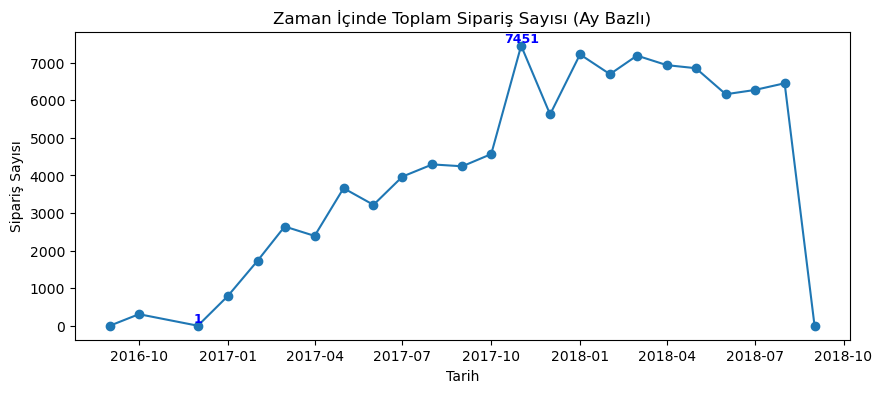

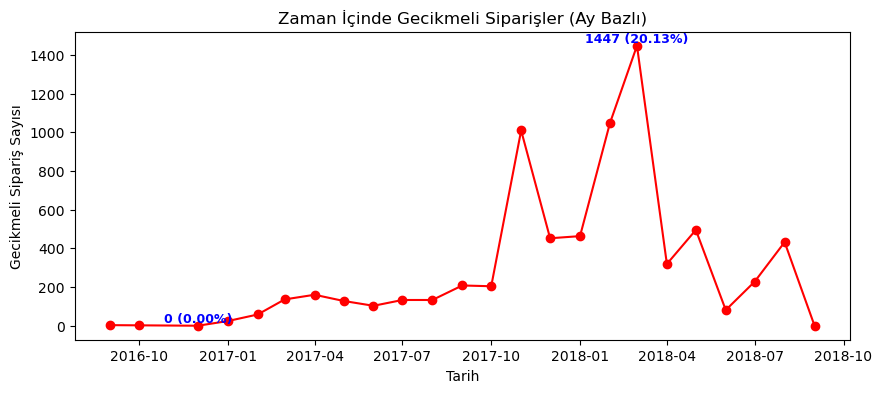

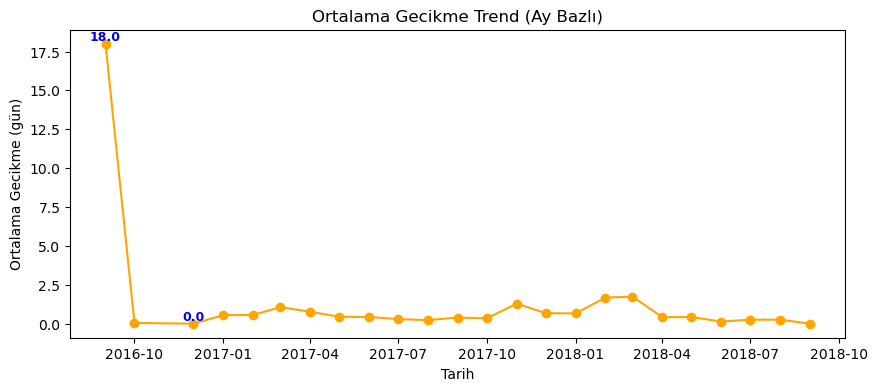

In [92]:
import matplotlib.pyplot as plt
# Yƒ±l / Ay / Hafta kolonlarƒ±nƒ± √ßƒ±kar
fact_order_shipments["year"]  = fact_order_shipments["order_purchase_timestamp"].dt.year
fact_order_shipments["month"] = fact_order_shipments["order_purchase_timestamp"].dt.month
fact_order_shipments["week"]  = fact_order_shipments["order_purchase_timestamp"].dt.isocalendar().week
# 3.2 Zaman i√ßinde toplam sipari≈ü sayƒ±sƒ± (ay bazlƒ±)
orders_per_month = (
    fact_order_shipments
    .groupby(["year","month"])["order_id_pref"]
    .nunique()
    .reset_index()
)
dates = pd.to_datetime(orders_per_month[["year","month"]].assign(day=1))
values = orders_per_month["order_id_pref"]

plt.figure(figsize=(10,4))
plt.plot(dates, values, marker="o")
# sadece min ve max i≈üaretle
min_idx, max_idx = values.idxmin(), values.idxmax()
for idx in [min_idx, max_idx]:
    plt.text(dates[idx], values[idx], str(values[idx]),
             ha="center", va="bottom", fontsize=9, fontweight="bold", color="blue")
plt.title("Zaman ƒ∞√ßinde Toplam Sipari≈ü Sayƒ±sƒ± (Ay Bazlƒ±)")
plt.xlabel("Tarih"); plt.ylabel("Sipari≈ü Sayƒ±sƒ±")
plt.show()

# 3.3 Zaman i√ßinde gecikmeli sipari≈ü sayƒ±sƒ± (ay bazlƒ± + y√ºzde)
orders_per_month = (
    fact_order_shipments
    .groupby(["year","month"])["order_id_pref"]
    .nunique()
    .reset_index()
    .rename(columns={"order_id_pref":"total_orders"})
)

late_per_month = (
    fact_order_shipments
    .groupby(["year","month"])["is_late"]
    .sum()
    .reset_index()
    .rename(columns={"is_late":"late_orders"})
)

# Join (aynƒ± yƒ±l/ay bazƒ±nda)
late_ratio = pd.merge(orders_per_month, late_per_month, on=["year","month"])
late_ratio["late_pct"] = (late_ratio["late_orders"] / late_ratio["total_orders"]) * 100

dates = pd.to_datetime(late_ratio[["year","month"]].assign(day=1))
values = late_ratio["late_orders"]

plt.figure(figsize=(10,4))
plt.plot(dates, values, marker="o", color="red")

# sadece min ve max i≈üaretle (adet + %)
min_idx, max_idx = values.idxmin(), values.idxmax()
for idx in [min_idx, max_idx]:
    count = late_ratio.loc[idx, "late_orders"]
    pct   = late_ratio.loc[idx, "late_pct"]
    plt.text(dates[idx], values[idx],
             f"{count} ({pct:.2f}%)",
             ha="center", va="bottom", fontsize=9, fontweight="bold", color="blue")

plt.title("Zaman ƒ∞√ßinde Gecikmeli Sipari≈üler (Ay Bazlƒ±)")
plt.xlabel("Tarih"); plt.ylabel("Gecikmeli Sipari≈ü Sayƒ±sƒ±")
plt.show()


# 3.4 Ortalama gecikme trendi (ay bazlƒ±)
delay_per_month = (
    fact_order_shipments
    .groupby(["year","month"])["delay_days"]
    .mean()
    .reset_index()
)
dates = pd.to_datetime(delay_per_month[["year","month"]].assign(day=1))
values = delay_per_month["delay_days"].round(2)

plt.figure(figsize=(10,4))
plt.plot(dates, values, marker="o", color="orange")
min_idx, max_idx = values.idxmin(), values.idxmax()
for idx in [min_idx, max_idx]:
    plt.text(dates[idx], values[idx], str(values[idx]),
             ha="center", va="bottom", fontsize=9, fontweight="bold", color="blue")
plt.title("Ortalama Gecikme Trend (Ay Bazlƒ±)")
plt.xlabel("Tarih"); plt.ylabel("Ortalama Gecikme (g√ºn)")
plt.show()


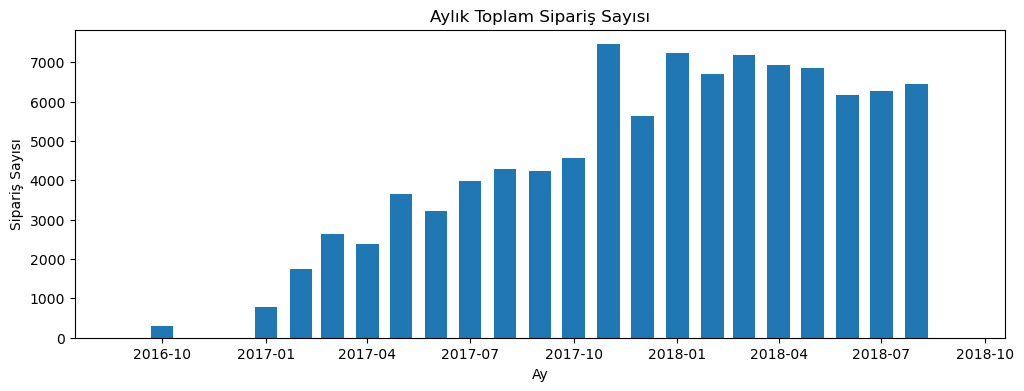

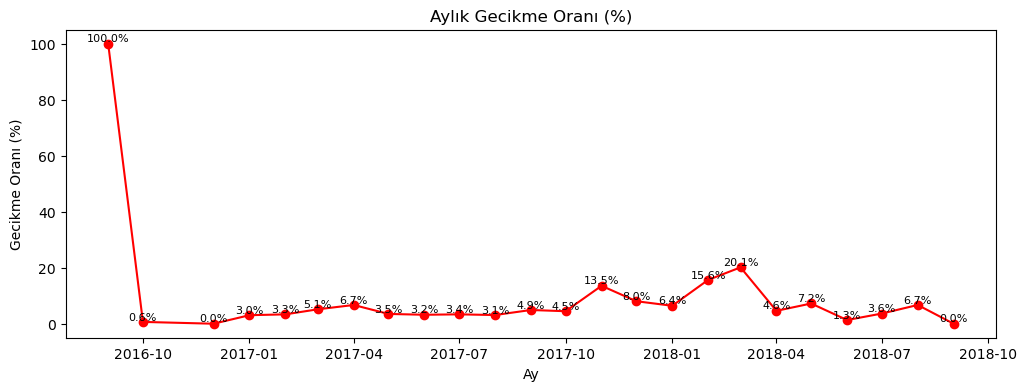

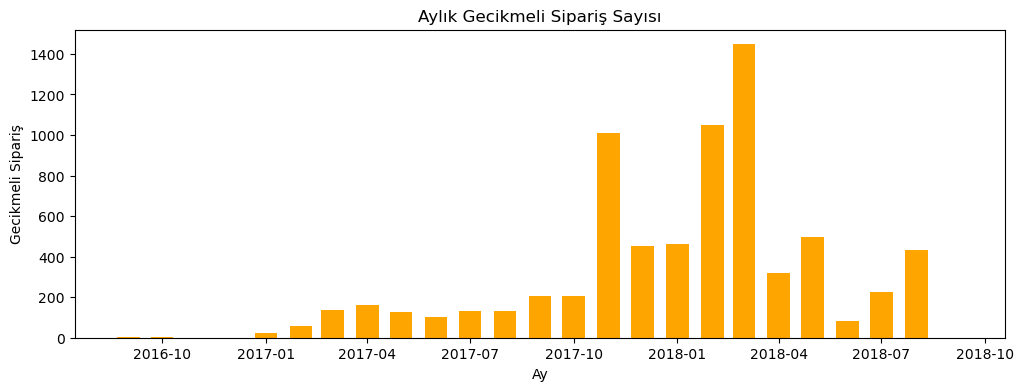

In [93]:
import matplotlib.pyplot as plt

# Aylƒ±k toplam ve gecikmeli sipari≈üler
monthly = (
    fact_order_shipments
    .groupby(["year","month"])
    .agg(total_orders=("order_id_pref","nunique"),
         late_orders=("is_late","sum"))
    .reset_index()
)
monthly["late_pct"] = (monthly["late_orders"] / monthly["total_orders"]) * 100
monthly["date"] = pd.to_datetime(monthly[["year","month"]].assign(day=1))

# --- Grafik 1: Aylƒ±k toplam sipari≈üler ---
plt.figure(figsize=(12,4))
plt.bar(monthly["date"], monthly["total_orders"], width=20)
plt.title("Aylƒ±k Toplam Sipari≈ü Sayƒ±sƒ±")
plt.xlabel("Ay"); plt.ylabel("Sipari≈ü Sayƒ±sƒ±")
plt.show()

# --- Grafik 2: Aylƒ±k gecikme oranƒ± ---
plt.figure(figsize=(12,4))
plt.plot(monthly["date"], monthly["late_pct"], marker="o", color="red")
for x,y in zip(monthly["date"], monthly["late_pct"]):
    plt.text(x, y, f"{y:.1f}%", ha="center", va="bottom", fontsize=8)
plt.title("Aylƒ±k Gecikme Oranƒ± (%)")
plt.xlabel("Ay"); plt.ylabel("Gecikme Oranƒ± (%)")
plt.show()

# --- Grafik 3: Aylƒ±k gecikmeli sipari≈ü sayƒ±sƒ± ---
plt.figure(figsize=(12,4))
plt.bar(monthly["date"], monthly["late_orders"], width=20, color="orange")
plt.title("Aylƒ±k Gecikmeli Sipari≈ü Sayƒ±sƒ±")
plt.xlabel("Ay"); plt.ylabel("Gecikmeli Sipari≈ü")
plt.show()

